# Automating Frequency and Pattern Analysis: FFT and Wavelets and OOP

At first glance, frequency analysis and object-oriented programming might not seem closely related – and that’s partially true. However, we will combine these approaches by integrating automated frequency analysis, such as Fourier Transformations and Wavelet Analysis, into a class structure, allowing us to streamline calculations for our datasets.

Let’s start by loading the SST data, as we did before.

Run the next cells.


In [1]:
# import necessary libraries

import requests

import xarray as xr
import numpy as np
from scipy.signal import detrend
import pycwt as wavelet
from scipy.stats import chi2

# Visualization
from matplotlib import pyplot as plt

import holoviews as hv

import hvplot.xarray
hv.extension('bokeh')






import warnings
warnings.filterwarnings("ignore")


#### Load SST (again) 
The next cell loads the data via OpenDAP if not stored locally.
Note: If multiple users attempt to access the data simultaneously, it may cause performance issues or delays due to the limitations of the OpenDAP server. To avoid this, consider downloading the dataset locally if possible and not already done.

In [2]:
#run the cell, if data are not stored locally
#load SST data
#url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
#ds_sst = xr.open_dataset(url)
#ds_sst

I stored data in [..Data/SST](../Data/SST/).  Make sure to check your path and filename accordingly.

In [3]:
## load SST data from local storage
filename = '../Data/SST/sst.mnmean.nc' 
ds_sst = xr.open_dataset(filename)
ds_sst

<xarray.Dataset> Size: 131MB
Dimensions:    (lat: 89, lon: 180, time: 2048, nbnds: 2)
Coordinates:
  * lat        (lat) float32 356B 88.0 86.0 84.0 82.0 ... -84.0 -86.0 -88.0
  * lon        (lon) float32 720B 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 16kB 1854-01-01 1854-02-01 ... 2024-08-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 33kB ...
    sst        (time, lat, lon) float32 131MB ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2024-09-04

#### Load Wind 
We also load wind data; these are CEMS wind data that we've previously worked with. However, this time they start from the year 2000 and are gridded on a 1° x 1° grid.

**Question**: Do you remember how data can be resampled?


The wind data can be downloaded directly from the cloud: [Wind Data](https://cloud.hcu-hamburg.de/nextcloud/s/GFzRHQaZPKxmZjY), or alternatively, by running the next cell.


In [4]:
## Define the cloud link
url = 'https://cloud.hcu-hamburg.de/nextcloud/s/GFzRHQaZPKxmZjY/download' 

## Download the file
filename = '../Data/Wind/cmems_wind_coarse.nc'
response = requests.get(url)

## Save the file locally
with open(filename, 'wb') as file:
    file.write(response.content)

## Now open the file using xarray
ds_wind = xr.open_dataset(filename, use_cftime=True)
ds_wind

# if its already stored locally you only need this:
#ds_wind = xr.open_dataset('../Data/Wind/cmems_wind_coarse.nc',use_cftime=True) # change path if necessary
#ds_wind


<xarray.Dataset> Size: 373MB
Dimensions:                 (time: 288, latitude: 180, longitude: 360)
Coordinates:
  * latitude                (latitude) float32 720B -89.5 -88.5 ... 88.5 89.5
  * longitude               (longitude) float32 1kB -179.5 -178.5 ... 179.5
  * time                    (time) object 2kB 2000-01-01 00:00:00 ... 2023-12...
Data variables:
    eastward_wind           (time, latitude, longitude) float64 149MB ...
    northward_wind          (time, latitude, longitude) float64 149MB ...
    number_of_observations  (time, latitude, longitude) float32 75MB ...
Attributes: (12/25)
    Conventions:                CF-1.6, ACDD-1.3
    date_created:               2023-10-11T11:54:21
    date_modified:              2023-10-11T11:54:21
    geospatial_lat_max:         89.875
    geospatial_lat_min:         -89.875
    geospatial_lat_resolution:  0.25
    ...                         ...
    project:                    Copernicus Marine Service Wind Thematic Assem...
    references:                 Copernicus Marine Service Product User Manual...
    summary:                    Global ocean monthly mean 10-m stress-equival...
    time_coverage_end:          2023-06-30T23:59:59
    time_coverage_start:        2023-06-01T00:00:00
    title:                       Global Ocean - Wind and Stress - Monthly - F...

**1. Exercise:** We want to slice the SST data to match the time period of the wind data. Please perform this operation in the next cell. You can also load the data into memory using `load()`.

In [5]:
# your code here
#ds_sst_24a = 
ds_sst24a = ds_sst.sel(time=slice('2000', '2023')).load()
#ds_sst24a
ds_sst24a

<xarray.Dataset> Size: 18MB
Dimensions:    (lat: 89, lon: 180, time: 288, nbnds: 2)
Coordinates:
  * lat        (lat) float32 356B 88.0 86.0 84.0 82.0 ... -84.0 -86.0 -88.0
  * lon        (lon) float32 720B 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 2kB 2000-01-01 2000-02-01 ... 2023-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 5kB 9.969e+36 9.969e+36 ... 9.969e+36
    sst        (time, lat, lon) float32 18MB -1.8 -1.8 -1.8 -1.8 ... nan nan nan
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2024-09-04

We need to calculate the detrended anomalies again. Do you remember how?

**2. Exercise**:  
Calculate the detrended anomalies of the sliced SST data. We already covered this in Session 2 and you have done this in your homeworks. If you're unsure how to proceed, revisit the notebooks and copy the relevant code snippets and make the necessary modifications.

In [6]:
# your code here

#ds_sst_chunked = ds_sst24a.chunk({'lat': 60, 'lon': 120}) 
sst_clim = ds_sst24a['sst'].groupby('time.month').mean(dim='time')
sst_anom = ds_sst24a['sst'].groupby('time.month') - sst_clim
# run the cell
sst_anom_detrended = xr.apply_ufunc(detrend, sst_anom.fillna(0),
                                    input_core_dims=[['time']],output_core_dims=[['time']] , dask='allowed').where(~sst_anom.isnull())


Optional: To verify that your calculations are correct, you can for example plot the data.

In [7]:
#your plot here. You can maybe plot the std of the anomalies
sst_anom_detrended.std(dim='time').hvplot()

:Image   [lon,lat]   (sst)

In the following we select a region in the eastern central Pacific for further analysis. This region is close to the NINO3.4 region, but more to the South-East. This adjustment allows us to compare the results with wind and Ekman parameters later, which isn't feasible directly on the equator.



We will slice the data again for latitude and longitude, and then calculate the spatial mean to get a time series for the region.

In [8]:
#run the cell
lat_start_sst, lat_end_sst = -5, -20
lon_start_sst, lon_end_sst = 240, 280  # for 0-360 120°W to 80°W
# calculate box-average 
latitudes = sst_anom_detrended['lat']
weights = np.cos(np.deg2rad(latitudes)).where(~sst_anom_detrended[0].isnull()).fillna(0)
sst_box = (sst_anom_detrended).sel(lon=slice(lon_start_sst, lon_end_sst), 
                                   lat=slice(lat_start_sst, lat_end_sst))
sst_box_mean = (sst_box.weighted(weights)).mean(dim=['lon', 'lat'])


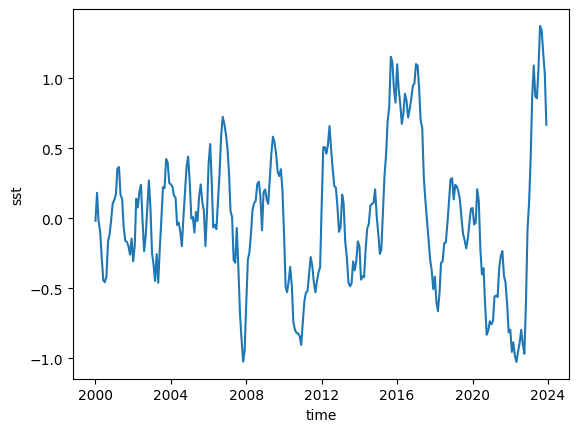

In [9]:
sst_box_mean.plot()

# ts shows interannual variations, and how these also change over time, 
# we see varying intensities and frequencies throughout the observed period.

## Fast Fourier Transform (FFT)


The Fast Fourier Transform (FFT) is a tool for identifying dominant frequencies/periods within a signal -> here in the SST anomalies, By transforming these time series into the frequency domain, we can uncover the main cycles that characterize variability in the anomaly data.

The power spectrum, obtained by squaring the amplitude of the FFT, reveals the strength of the various frequencies present in the time series. Higher values in the power spectrum indicate a stronger presence of the corresponding frequency in the original time series. By setting a significance threshold—calculated as the mean plus two standard deviations of the power spectrum—we can highlight the most prominent frequencies, filtering them from background noise.


Execute the following two code cells to begin the analysis.

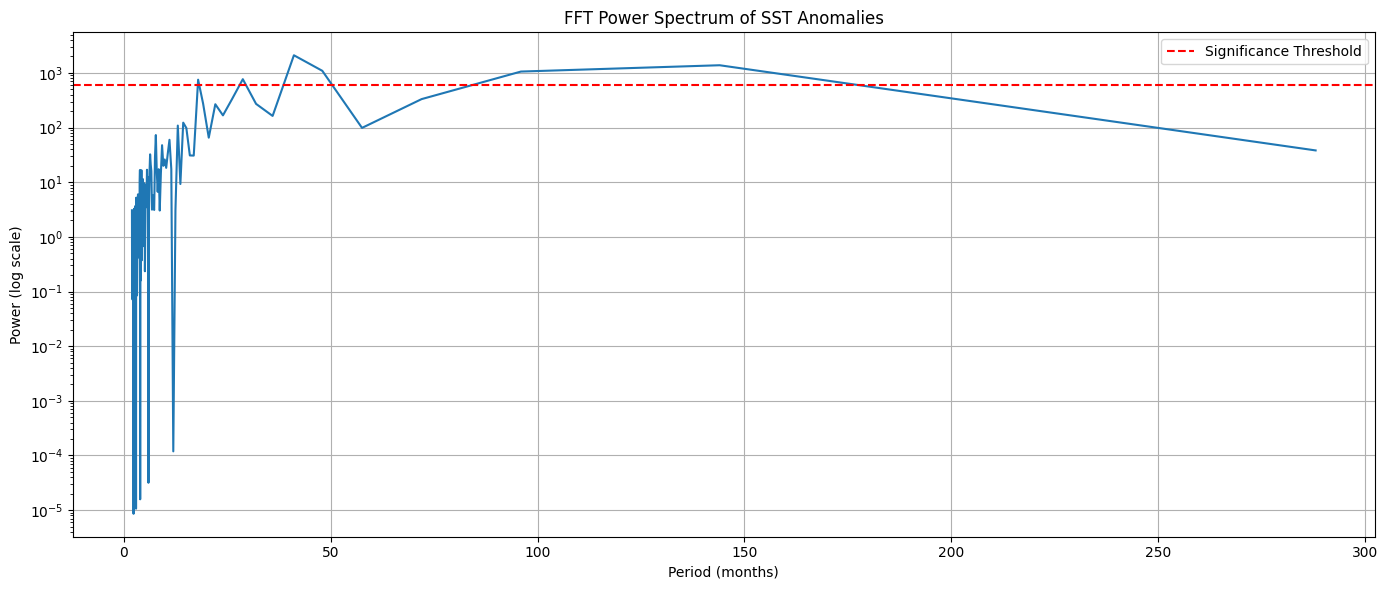

In [10]:
# run the cell
# Compute the Fast Fourier Transform (FFT) of the sst_box_mean
fft_sst = np.fft.fft(sst_box_mean)

# explaination: FFT is an algorithm that converts signal from time domain to the frequency domain 
# -> complex array and 
# Amplitude=sqrt(real2+imaginary2) and Phase as the angle of the complex value  = arctan(imaginary/real) 


n = len(sst_box_mean) # number of data points 
# compute corresponding frequency values for the FFT output
freq = np.fft.fftfreq(n, d=1)  # with the sampling intervall,  d=1 assumes monthly data points
periods = 1 / freq  # Periods will be in months

# Compute the Power Spectrum (squaring the absolute values of FFT coefficients) 
# -> quantify signal's strength
power_sst = np.abs(fft_sst)**2

# Calculate a simple significance threshold, here set at mean + 2 * standard deviation 
# -> frequencies with power spectrum exceeding the threshold are considered significant
threshold_sst = np.mean(power_sst) + 2*np.std(power_sst)



# Plot the Power Spectrum with Periods on a logarithmic scale
valid_periods = periods[:n // 2] > 0  #  Exclude zero and negative frequencies (FFT creates symmetric output)
plt.figure(figsize=(14, 6))

# SST Plot
plt.subplot(1, 1, 1)

plt.semilogy(periods[:n // 2][valid_periods], power_sst[:n // 2][valid_periods]) # Plot only positive frequencies and their power
plt.axhline(y=threshold_sst, color='r', linestyle='--', label='Significance Threshold')
plt.title('FFT Power Spectrum of SST Anomalies')
plt.xlabel('Period (months)')
plt.ylabel('Power (log scale)')
plt.grid(True)  # Adding grid lines
plt.legend() # and a legend


plt.tight_layout()
plt.show()


This code transforms the time series into the frequency domain using FFT.  
It identifies the dominant periods with high power, which are highlighted by comparing them to a significance thresholdand the plot shows the dominant frequencies (but we plot the periods) in the SST anomaly data.  

It can be challenging to visually identify the dominant cycles directly from the plot. To make this easier, we will print the dominant periods in months. Run the next cell to see the results.

In [11]:
# run the cell
# Find the indices of significant power values
valid_periods = periods[:n // 2] > 0  # Exclude the infinite period at zero frequency
significant_sst_indices = np.where(power_sst[:n // 2][valid_periods] > threshold_sst)[0]


# Extract the corresponding significant periods
significant_sst_periods = periods[:n // 2][valid_periods][significant_sst_indices]


# Filter out infinite values from significant_sst_periods
significant_sst_periods = significant_sst_periods[np.isfinite(significant_sst_periods)]

# Print the significant periods for both time series
print("Significant SST Periods (months):", significant_sst_periods)


Significant SST Periods (months): [144.          96.          48.          41.14285714  28.8
  18.        ]


We identified dominant periods in our data: approximately 144 months (12 years), 96 months, 48 months, 41 months, 28 and 18 months. These findings correspond to known climatic cycles:

- The 144-month cycle could be related to large-scale climatic phenomena. For instance, it may be linked to the the Pacific Decadal Oscillation (PDO), a multi-decadal climate variability pattern typically oscillating over periods of 20-30 years, which significantly impacts the North Pacific and broader global climate. Furthermore, it could be linked to the solar sunspot cycle, which spans around 11 years and affects solar radiation, thereby influencing global climatic patterns (for further reading, see this research on [solar cycles](https://iopscience.iop.org/article/10.1088/1748-9326/abfe8b)). Thus, the identified long-term cycles may point to the interplay between these and other slow-moving climate processes.

- The 48, 41, 28-month cyle could align  with the El Niño-Southern Oscillation (ENSO) events, which typically have a [2 to 7-year cycle](https://www.who.int/news-room/fact-sheets/detail/el-nino-southern-oscillation-(enso)). ENSO significantly impacts sea surface temperatures, particularly in the central and eastern tropical Pacific, where the analyzed region (20°S to 5°S and 80°W to 120°W) is located. ENSO events influence global weather and climate patterns, making these cycles highly relevant to our analysis.

Now that we have identified significant periods in our data, we want to understand how these periods vary over time.


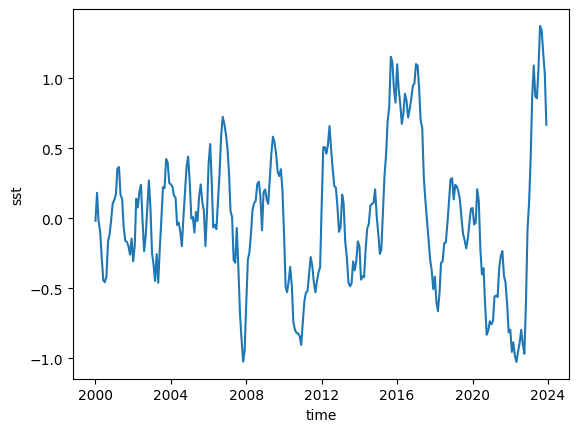

In [12]:
sst_box_mean.plot()
# ts shows interannual variations, and how these also change over time, 
# we see varying intensities and frequencies throughout the observed period.

# Wavelet Analysis

This is where Wavelet Analysis comes into play, offering a method to extract both frequency and time information from a signal simultaneously, unlike FFT, which only offers a global frequency spectrum. This makes it especially useful for analyzing non-stationary signals where frequency content changes over time.



### What is Wavelet Analysis?

Wavelet analysis breaks a signal into time and frequency components using localized wave-like functions called wavelets. The Morlet wavelet, often used for climate data, effectively captures oscillatory patterns while balancing time and frequency localization.

 - The wavelet slides/shifts over the signal at various time points and scales, recording the amplitude and phase of oscillatory patterns, revealing how these vary in strength and timing.

This method is particularly valuable for identifying and understanding climatic cycles and their temporal variability.

In [13]:
# run the cell

# time array for 288 months 
time = np.arange(288)

# Compute wavelet transform
dt = 1  # Monthly time step
mother_wavelet = wavelet.Morlet(6) # standard, e.g. 5 means higher temp resolution, ess frequence reslution..

# Compute cntinuous wavelet transform of SST anaomalies 
# -> transforms the time series into a 2D array of frequency vs. time
sst_wavelet, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(sst_box_mean.values, dt, wavelet=mother_wavelet)

# Ensure the dimensions of the wavelet match the time series
sst_wavelet = sst_wavelet[:, :len(time)]  # Match wavelet data to the time series

# Calculate the wavelet power (square of the wavelet transforms amplitude)
power = np.abs(sst_wavelet) ** 2

# Manually calculate significance using chi-square distribution
alpha = 0.05
dof = 2  # Degrees of freedom for Morlet wavelet
signif_level = power.mean() * chi2.ppf(1 - alpha, dof) / dof
signif = power / signif_level # ratio is caclulated as power normalized by the significance threshold

# Average the power and significance over time for each period
mean_power = np.mean(power, axis=1)  # Average power over time for each period
mean_significance = np.mean(signif, axis=1)  # Average significance over time for each period

# Convert frequencies to periods (in months)
periods = 1 / freqs


**How Wavelet Analysis Works in the Code**:

In the provided wavelet code, we transform the SST anomaly time series into the wavelet domain using the Morlet wavelet, producing a power spectrum that shows the strength of different periods over time. This spectrum is visualized as a contour plot, where color intensity represents signal power at specific periods and times.

The Cone of Influence (COI) marks regions where edge effects from the finite time series may distort results. Values inside the COI are more reliable than those near the edges.


Significance levels are calculated using the chi-square distribution to identify statistically significant periods and times, shown as contours over the wavelet spectrum. These highlight areas of meaningful variability.

**<p style="color:royalblue;">For a step-by-step visual explanation, refer to the notebook  [`wavelet_demo.ipynb`](wavelet_demo.ipynb), providing a clearer understanding of the transformation and interpretation of the results. Please take your time to review it at home.</p>**

Next: We plot our Wavelet spectrum

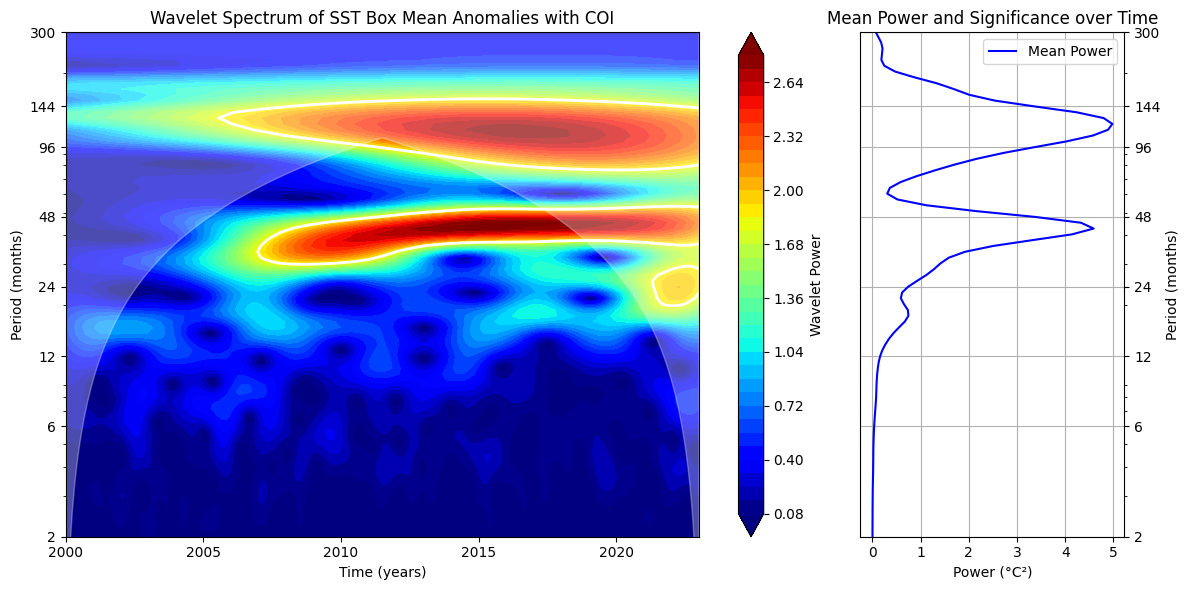

In [14]:
years = np.linspace(2000, 2023, num=288)


# Create the figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(12, 6))

# Plot the wavelet power spectrum on the left subplot
contour = ax1.contourf(years, periods, np.abs(sst_wavelet), levels=39, extend='both', cmap='jet')

# Add significance levels manually
ax1.contour(years, periods, signif, levels=[1.0], colors='white', linewidths=2)

# Plot the cone of influence (COI) -> indicates region where edge effects make the results less reliable
ax1.fill_between(years, coi, periods[-1], color='white', alpha=0.3)

# Set the x-axis to show years and y-axis for periods
ax1.set_xlabel('Time (years)')
ax1.set_ylabel('Period (months)')
ax1.set_yscale('log')
ax1.set_ylim(2, 144)  # Start the y-axis at 2 months to avoid displaying below 2
ax1.set_yticks([2, 6, 12, 24, 48, 96, 144, 300])
ax1.set_yticklabels(['2', '6', '12', '24', '48', '96', '144','300'])
ax1.set_title('Wavelet Spectrum of SST Box Mean Anomalies with COI')

# Add color bar to the left subplot
cbar = plt.colorbar(contour, ax=ax1, label='Wavelet Power')

# Plot the mean power and significance as a function of period on the right subplot
ax2.plot(mean_power, periods, 'b', label='Mean Power')
#ax2.plot(mean_significance, periods, 'r--', label='Mean Significance')
ax2.set_yscale('log')
ax2.set_ylim(ax1.get_ylim())  # Match the y-axis limits with the left plot
ax2.set_ylabel('Period (months)')  # Y-axis now matches the wavelet plot
ax2.set_yticks([2, 6, 12, 24, 48, 96, 144, 300])
ax2.set_yticklabels(['2', '6', '12', '24', '48', '96', '144', '300'])
ax2.set_xlabel('Power (°C²)')
ax2.set_title('Mean Power and Significance over Time')

# Add grid, legend, and format the plot
ax2.grid(True)
ax2.legend()
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

# Show the full plot
plt.tight_layout()
plt.show()

# This visualization allows us to identify the periods where the SST anomalies show significant variability and how these patterns evolve over time.


This plot demonstrates the presence and evolution of dominant signals in the SST anomalies over time:

144-Month Signal (12 Years):
    This signal is consistently strong after 2007, indicating the influence of long-term climatic phenomena, such as the Pacific Decadal Oscillation (PDO).

48-Month Signal (4 Years):
    This period is particularly pronounced after 2008 aligning with known ENSO variability cycles that often peak in this range.

~24-Month Signal (2 Years):
    This shorter signal becomes prominent around 2023, potentially linked to a strong Niño event or another oscillation.


## Object-Oriented Programming

Ok, this was a lot of code – once again we calculated anomalies, detrended data, and applied several analyses. Now, we want to apply the same steps to other datasets, but copying, pasting, and modifying all the code each time isn’t efficient. We’ve already made use of functions and modules, but there’s another tool available to us: **Object-Oriented Programming (OOP)** using classes.

OOP organizes code into reusable objects with attributes and methods, which can enhance scalability, modularity, and reusability compared to standalone functions and modules.


A class is like a blueprint for a house. It defines the general structure and attributes, such as the number of rooms or the size of the garden, but it’s not a specific house yet. An object is the actual house built from that blueprint. If you remove the kitchen from one specific house (object), other houses remain unaffected. However, if you remove the kitchen from the blueprint (class), no house built from that blueprint will have a kitchen.

In the same way, the [`TimeSeriesAnalyzer`](../Modules/timeseries_analyzer.py) class is a blueprint for processing climate data. It defines attributes like the dataset to be analyzed and methods like compute_fft or wavelet_analysis to perform frequency analyses. When we create an instance (object) of this class, such as `processor = TimeSeriesAnalyzer(ds_sst24a)`, it applies these predefined methods to the specific dataset (ds_sst24a). This allows us to analyze various datasets consistently without rewriting the analysis code each time, much like building different houses from the same blueprint.


<p style="color:royalblue;">Note that this is a simplified introduction to Object-Oriented Programming (OOP). In practice, we often work with more sophisticated classes, such as those provided by <code>xarray</code>, which we've been using throughout the course to efficiently handle multidimensional climate data.</p>


A class consists of attributes, which store data, and methods, which are functions that define behaviors or actions the class can perform.


#### Why Classes are Helpful:

**Efficiency**: Instead of running individual scripts for different datasets, the class provides a unified framework that can process any dataset with the same structure (daily or monthly resoulution, 3 (time, lat, lon) or 4 dimensions (time, depth, lat, lon)).  
    
**Modularity**: Methods are self-contained, so debugging and extending functionality is much simpler.
    
**Reusability**: The class can be reused across different datasets, whether it’s SST, wind data, or other climate variables.

**Scalability**: As the analysis grows more complex, we can continue adding methods and functionality to the class without needing to rewrite existing code.

Applying the Class to Your Data

Let’s now quickly reproduce the calculations we have done before, but this time using the TimeSeriesAnalyzer class to automate the process. Afterward, you’ll get a chance to do the same for the wind data as a major task.


In [15]:
# run the cell
# append the Modules folder to path -> we have done it with the ekman_properties.py module before
import sys
sys.path.append('../Modules')  

# import
from timeseries_analyzer import TimeSeriesAnalyzer 

Print the docstring of the `TimeSeriesAnalyzer` Class to get a quick overview:

In [16]:
help(xr)

Help on package xarray:

NAME
    xarray

PACKAGE CONTENTS
    backends (package)
    coding (package)
    conventions
    convert
    core (package)
    groupers
    indexes (package)
    namedarray (package)
    plot (package)
    static (package)
    testing (package)
    tests (package)
    tutorial
    util (package)

CLASSES
    builtins.RuntimeWarning(builtins.Warning)
        xarray.coding.variables.SerializationWarning
    builtins.ValueError(builtins.Exception)
        xarray.core.merge.MergeError
    builtins.object
        xarray.core.indexes.Index
        xarray.core.indexing.IndexSelResult
        xarray.core.merge.Context
        xarray.core.options.set_options
    collections.abc.Mapping(collections.abc.Collection)
        xarray.core.dataset.Dataset(xarray.core.common.DataWithCoords, xarray.core._aggregations.DatasetAggregations, xarray.core.arithmetic.DatasetArithmetic, collections.abc.Mapping)
    pandas.core.indexes.base.Index(pandas.core.base.IndexOpsMixin, pandas.

In [17]:
# run the cell
# Create an instance of TimeSeriesAnalyzer with the SST dataset, naming it processor, but feel free to choose any name you prefer.
processor = TimeSeriesAnalyzer(ds_sst24a)


# Compute anomalies
sst_anomalies = processor.compute_anomalies_and_detrend()
print("Anomalies:\n", sst_anomalies)

Anomalies:
 <xarray.Dataset> Size: 18MB
Dimensions:    (time: 288, nbnds: 2, lat: 89, lon: 180)
Coordinates:
  * time       (time) datetime64[ns] 2kB 2000-01-01 2000-02-01 ... 2023-12-01
    month      (time) int64 2kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
  * lat        (lat) float32 356B 88.0 86.0 84.0 82.0 ... -84.0 -86.0 -88.0
  * lon        (lon) float32 720B 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 5kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    sst        (time, lat, lon) float32 18MB 0.001474 0.001381 ... nan nan
Attributes:
    description:  Detrended anomalies of all variables.


In [18]:
#annual_amplitude=processor.compute_annual_amplitude()
#annual_amplitude['sst'].hvplot()

With `processor.plot_std_and_annual_var('sst', vmax=5)`, we calculate and plot the standard deviation (variability) of the SST data, along with the annual variability. This gives us a quick visual representation of how the data varies over time and across seasons. The `vmax=5` parameter sets the maximum value of the colorbar, controlling the upper bound for the variability being displayed in the plot. This helps in visually interpreting the intensity of variations across the dataset.

Run the next cell


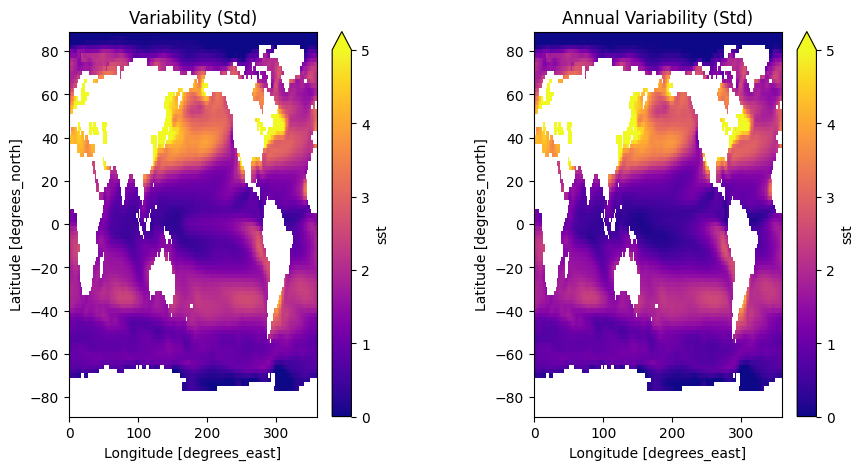

In [19]:
# run the cell
# calculate and plot variability and annual variability
processor.plot_std_and_annual_var('sst', vmax=5)

With `processor.compute_fft(variable='sst', lon_min=240, lon_max=280, lat_min=-5, lat_max=-20)`, we compute the Fast Fourier Transform (FFT) of the SST anomalies for the specified spatial region. This process helps us identify the dominant periods in the time series, revealing the most significant cycles present in the SST data over time.

In [20]:
#Perform FFT analysis
processor.compute_fft(variable='sst', lon_min=240, lon_max=280, lat_min=-5, lat_max=-20)


Significant Periods (in time units) sst : [144.          96.          48.          41.14285714  28.8
  18.        ]


With `processor.wavelet_analysis(variable='sst', lon_min=240, lon_max=280, lat_min=-5, lat_max=-20)`, we perform a wavelet analysis to examine how the significant frequencies and periods change over time. This method allows us to explore time-localized variations in the SST anomalies, giving us a deeper insight into the temporal evolution of different cycles.

Run the next cell.

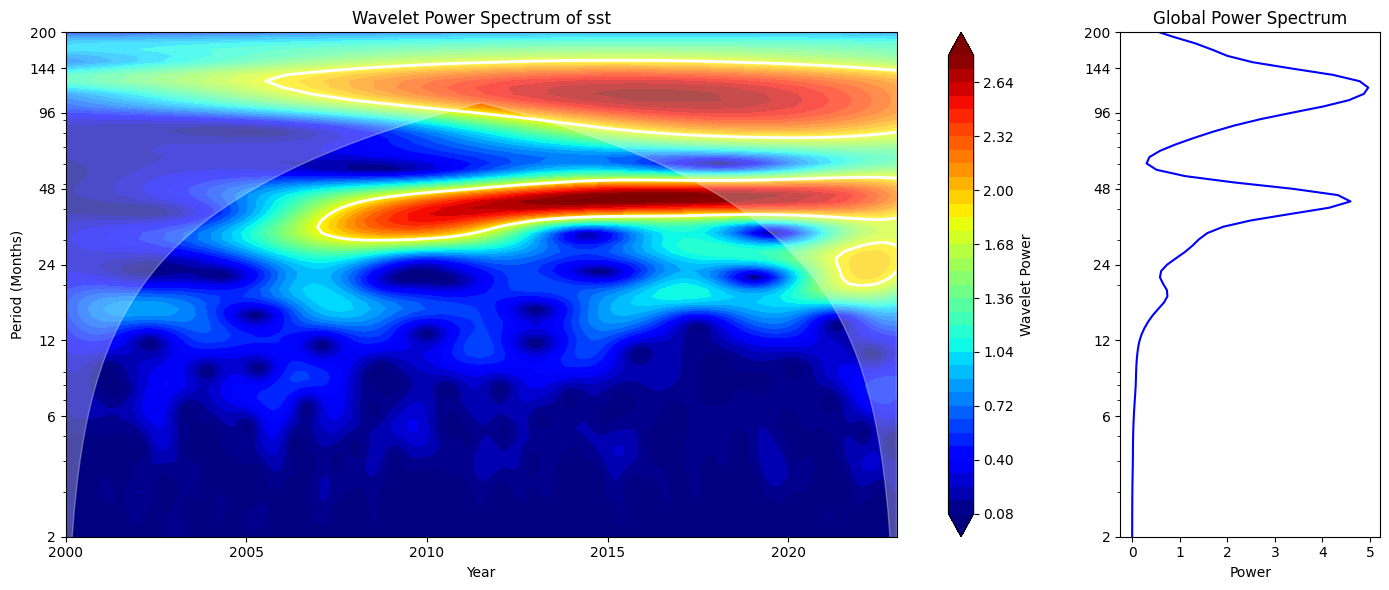

In [21]:

# run the cell
# wavelet analysis
processor.wavelet_analysis(variable='sst', lon_min=240, lon_max=280, lat_min=-5, lat_max=-20)

In [22]:
# finally save the anomalies
processor.save_results('../Data/SST/SST_Anomalies.nc')



With just a few lines of code, we were able to recreate and automate all the calculations we performed earlier—from calculating detrended anomalies to performing FFT and wavelet analyses, as well as obtaining a quick overview of the variabilities within each dataset. The class simplifies these processes and makes them easily applicable to different datasets.



For a general overview of how object-oriented modeling and programming work, please visit this 
[Storymap](https://storymaps.arcgis.com/stories/dd9d06f89a63400c96927de117a5b28a). The text is in German, but most browsers offer automatic translation. The article provides a closer look at the programming paradigm and dives into the benefits of encapsulation, inheritance, polymorphism, and abstraction.


**3. Exercise**

Now it’s your turn to adapt this analysis for the wind data. Before you begin, you need to calculate the Ekman properties (e.g., Ekman transport, Ekman pumping). Do you remember how? Once you’ve calculated these, save them as new variables within your wind dataset.

Your task:

1. Calculate Ekman properties and store them as new variables within your `ds_wind`. Apply a mask using the variable `number_of_observations`    
2. Create an instance of the TimeSeriesAnalyzer class for the wind data.  
3. Follow the same analysis steps that we performed for the SST data:
    - compute anomalies  
    - Compute and plot the variability and annual variability of **vertical Ekman velocity** .  
    - Perform an FFT analysis of **vertical Ekman velocity** to determine the dominant periods in the wind data. Choose the same region as SST. Be careful to check the lat and lon dimensions of your wind dataset before starting, as they may differ from the SST data. Adjust the slicing accordingly to match the same region.  
    - Conduct a wavelet analysis of **vertical Ekman velocity**  to investigate the temporal evolution of these dominant periods.
Finally, compare the dominant frequencies of the SST and the vertical Ekman velocity to see how they align or differ.

Good luck!


In [23]:
# run the cell

from ekman_dynamics import compute_ekman_properties

In [24]:
# your code here to calculate Ekman properties and store them in ds_wind

curl_tau, M_u, M_v, mean_Ekman, w_E = compute_ekman_properties(ds_wind.eastward_wind, ds_wind.northward_wind)

ds_wind['w_E'] = w_E
ds_wind['curl_tau'] = curl_tau
ds_wind['mean_Ekman'] = mean_Ekman
ds_wind['M_u'] = M_u
ds_wind['M_v'] = M_v

In [25]:
# your code here to apply a mask using number_of_observations

#'number_of_observations' is the variable used as a mask
mask = ds_wind.number_of_observations.notnull()

# Apply the mask to the eastward wind data
ds_wind = ds_wind.where(mask)

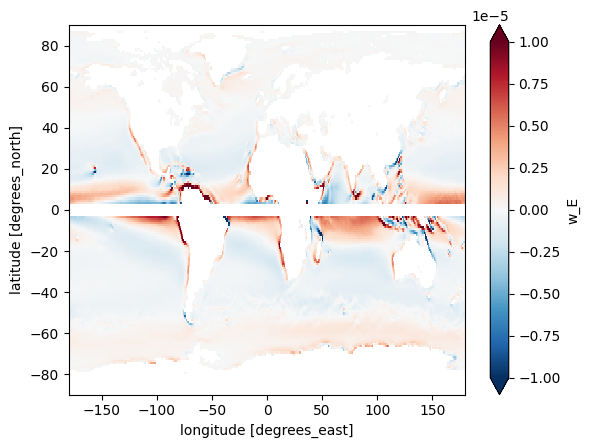

In [26]:
# Optional: plot the temporal mean of a variable to check if everything is correct

ds_wind['w_E'].mean(dim='time').plot(vmin=-1e-5,vmax=1e-5,cmap='RdBu_r')

In [27]:
# your code here
# Create an instance of TimeSeriesAnalyzer with the Wind dataset
processor_wind = TimeSeriesAnalyzer(ds_wind)


# Compute anomalies
wind_anomalies = processor_wind.compute_anomalies_and_detrend()
#print("Anomalies:\n", anomalies)

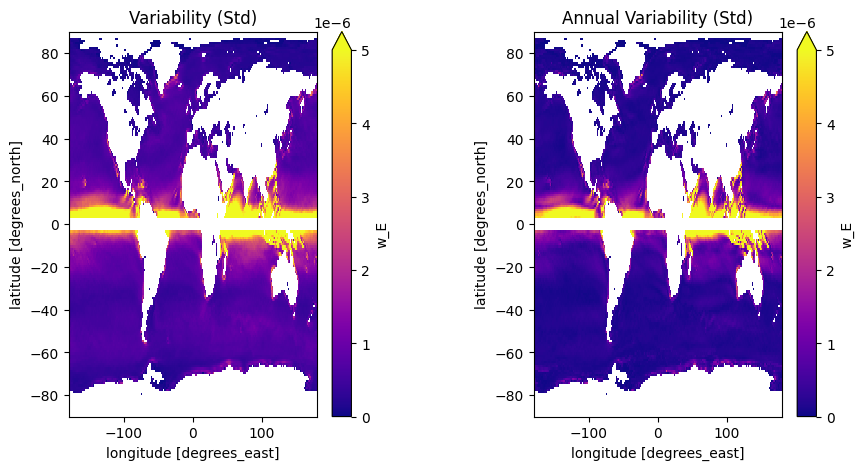

In [28]:
# your code here to calculate and plot std and annual std of vertical Ekman velocity

processor_wind.plot_std_and_annual_var('w_E', vmax=.5e-5)

In [29]:
# your code here: check lat,lon carefully

#Perform FFT analysis
processor_wind.compute_fft(variable='w_E', lon_min=-120, lon_max=-80, lat_min=-20, lat_max=-5)

Significant Periods (in time units) w_E : [144.          41.14285714  19.2         18.          13.71428571
   5.64705882]


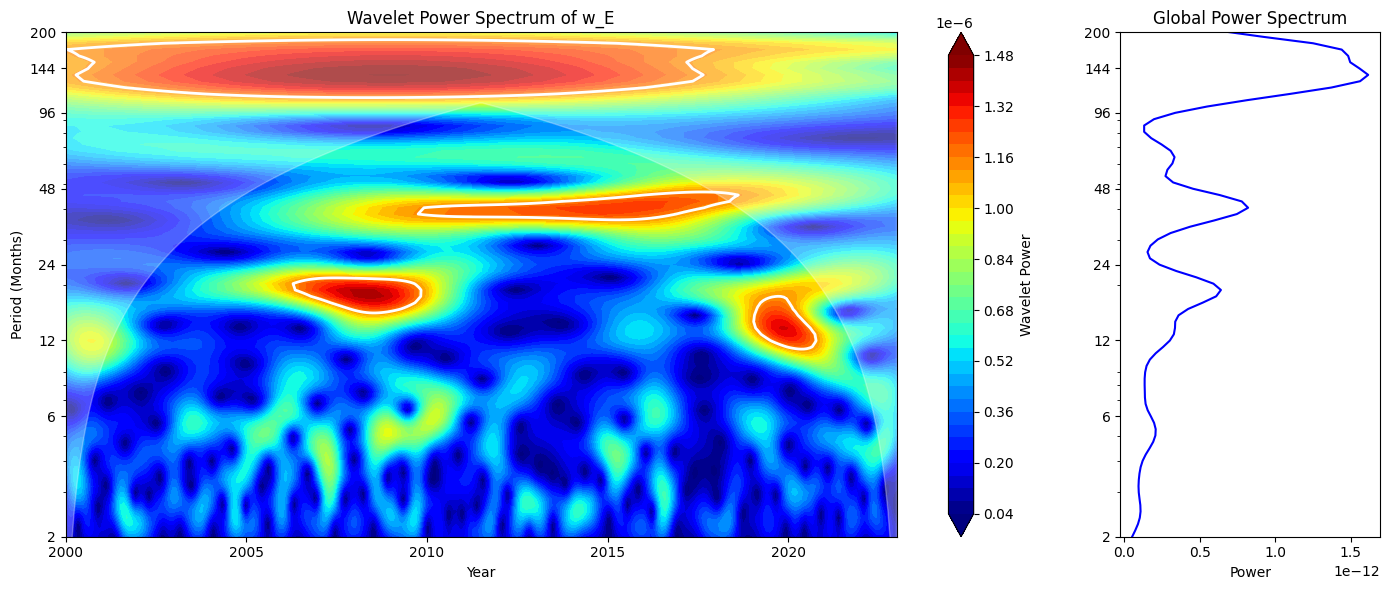

In [30]:
# your code here: check lat,lon carefully
# wavelet analysis
processor_wind.wavelet_analysis(variable='w_E', lon_min=-120, lon_max=-80, lat_min=-20, lat_max=-5)

Compare the power spectra of SST and vertical Ekman velocity from both the FFT and wavelet analyses. Discuss the dominant periods you observe in each dataset, and how they correspond to one another or not. 

Summarize your findings, highlighting any similarities or differences in the frequency and temporal patterns between the two datasets.



Your Observations: 

....

In [31]:


#save files

#processor.save_results('../Data/SST/SST_Anomalies.nc')
#processor_wind.save_results('../Data/Wind/Wind_Anomalies.nc')


In [32]:
#close files

ds_sst.close()
ds_wind.close()

Through the FFT and wavelet analyses, we have uncovered the dominant periods and temporal variability in both SST and vertical Ekman velocity data. This exploration allows us to understand how these variables fluctuate across different timescales. By investigating variability on various frequencies, such as interannual (e.g., ENSO) or decadal (e.g., PDO) scales, we can better comprehend the underlying dynamics driving changes in ocean patterns.

The comparison of SST and vertical Ekman velocity highlights how these phenomena are interconnected, with similar dominant periods reflecting common external forcings like wind patterns and ocean-atmosphere interactions. Understanding these relationships is crucial for interpreting variability in climate systems and their impacts on oceanographic processes.

In addition to the insights we've gained from our analyses of SST and vertical Ekman velocity, it's important to recognize that any analysis of variability, frequencies, or patterns is highly dependent on the dataset used—especially the length of the time series. For example, a short time series of just one year would not reveal interannual variability, while datasets shorter than 10 years would struggle to capture decadal fluctuations.

Furthermore, the prominence of certain signals can vary depending on the specific time period analyzed. For instance, a wavelet analysis conducted for the years 1900–1920 might reveal different patterns compared to an analysis for 2000–2020, highlighting that ocean-atmosphere variability evolves over time. This makes it crucial to consider both the temporal coverage and the length of the dataset when interpreting the results of frequency analyses.

**Extra Exercise** 

Perform the analysis using the longer SST dataset, which spans from 1854 to 2024. You are encouraged to explore various time periods and lengths of the time series. Investigate how different temporal windows affect the identified dominant frequencies, variabilities, and patterns. This will help you understand the impact of dataset length and coverage on your frequency and variability analyses.


## EOF Analysis

For a more comprehensive understanding of such variability, longer datasets and a careful examination of different time windows are essential, as they allow us to uncover patterns and signals that might otherwise be missed in shorter or less representative datasets.In addition to the analyses we performed, further investigations can be carried out using advanced techniques like **Empirical Orthogonal Function (EOF) analysis**. EOF analysis is a statistical method used to identify dominant modes of variability in spatiotemporal data. It helps in simplifying the complex relationships within the data by decomposing the dataset into principal components.

For a detailed example of how EOF analysis is applied, refer to the accompanying notebook [`EOFanalysis_demo.ipynb`](EOFanalysis_demo.ipynb). This analysis can provide deeper insights into the spatial patterns of variability, complementing the frequency-based methods we've already explored.